<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Hidden_Markov_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hmmlearn
!pip install yfinance

     |████████████████████████████████| 374 kB 33.5 MB/s 
     |████████████████████████████████| 6.3 MB 40.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=903957df6b2bd41c954a1c2069650b8cc73755518e0d358aa07b35c49028c7d2
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
from hmmlearn import hmm
import yfinance as yf

In [3]:
df = yf.download('^nsei',start='2015-01-01')#period='max'
#median = df.loc[df['Close']<10, 'Close'].median()
#df["Close"] = np.where(df["Close"] <10, df.Close.mean(),df['Close'])


[*********************100%***********************]  1 of 1 completed


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

In [5]:
df.head(1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,8288.700195,8410.599609,8288.700195,8395.450195,8395.450195,101900


In [6]:
returns = np.log(df['Close']).diff(1)

In [7]:
returns.dropna(inplace=True)

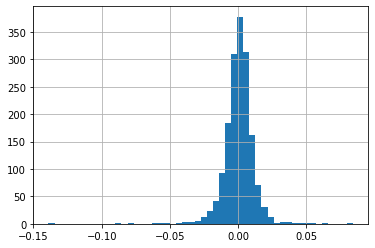

In [8]:
returns.hist(bins=50);

In [9]:
model = hmm.GaussianHMM(n_components=2, covariance_type="diag")

In [10]:
#retu = np.column_stack([returns]) =====> returns.to_numpy().reshape(-1, 1)


In [11]:
X = returns.to_numpy().reshape(-1, 1)
print(X.shape)
model.fit(X)

(1665, 1)


GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=2, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [12]:
Z = model.predict(X)

In [13]:
Z

array([0, 1, 0, ..., 0, 0, 0], dtype=int32)

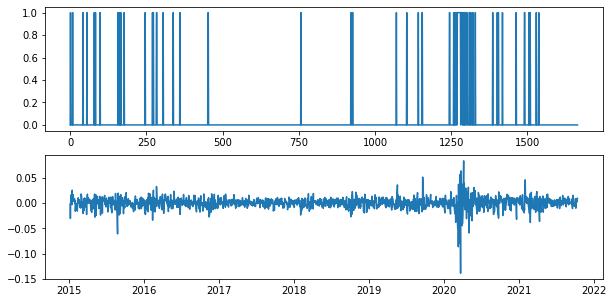

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.subplot(211)
plt.plot(Z)
plt.subplot(212)
plt.plot(returns);

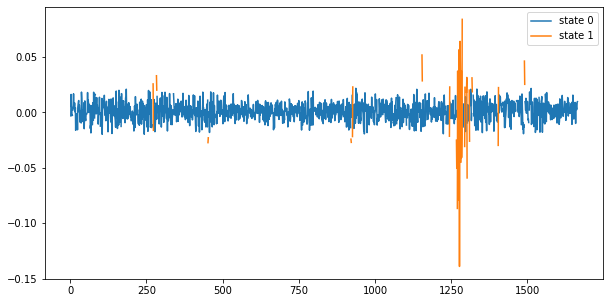

In [15]:
# we want to draw different segments in different colors according to state
fig, ax = plt.subplots(figsize=(10, 5))

# first create arrays with nan
returns0 = np.empty(len(Z))
returns1 = np.empty(len(Z))
returns0[:] = np.nan
returns1[:] = np.nan

# fill in the values only if the state is the one corresponding to the array
returns0[Z == 0] = returns[Z == 0]
returns1[Z == 1] = returns[Z == 1]
plt.plot(returns0, label='state 0')
plt.plot(returns1, label='state 1')
plt.legend();

In [16]:
# transition matrix
model.transmat_

array([[0.88279807, 0.11720193],
       [0.63793612, 0.36206388]])

In [17]:
'''
# try to set the transition matrix intuitively
model.transmat_ = np.array([
  [0.999, 0.001],
  [0.001, 0.999],                           
])
'''

'\n# try to set the transition matrix intuitively\nmodel.transmat_ = np.array([\n  [0.999, 0.001],\n  [0.001, 0.999],                           \n])\n'

In [18]:
returns[Z==0].mean()

0.0009112210573815235

In [19]:
returns[Z==1].mean()

-0.008287123093712245

In [20]:
zero=(returns[Z==0]).mean()

In [21]:
one=(returns[Z==1]).mean()

In [22]:
print(f'zero {zero}')
print(f'one {one}')

zero 0.0009112210573815235
one -0.008287123093712245


In [23]:
# run inference again
Z = model.predict(X)
# first create arrays with nan
returns_vol = np.empty(len(Z))
returns_vol[:] = np.nan
if one>0:
  returns_vol[Z==0]=1
  returns_vol[Z==1]=0
elif one<0:
  returns_vol[Z==0]=0
  returns_vol[Z==1]=1
ret=returns.reset_index()
zi= pd.concat([ret.Date,ret.Close,pd.Series(Z),pd.Series(returns_vol)],axis=1)
zi=zi.set_index('Date')
zi.columns=['pct_chg','pred','Volatility']



In [24]:
#print(abcd)

In [25]:
zi.to_csv('daa.csv')

In [26]:
def plot_buy_sell_signal(df):
  reg1=[]
  reg2=[]
  for i in range(len(df)):
    if df.Volatility.iloc[i]==1 and df.Volatility.iloc[i-1]==0 :
      reg1.append(i)
    elif df.Volatility.iloc[i]==0 and df.Volatility.iloc[i-1]==1 :
      reg2.append(i)
  
  return reg1,reg2

In [27]:
sell,buy=plot_buy_sell_signal(zi)

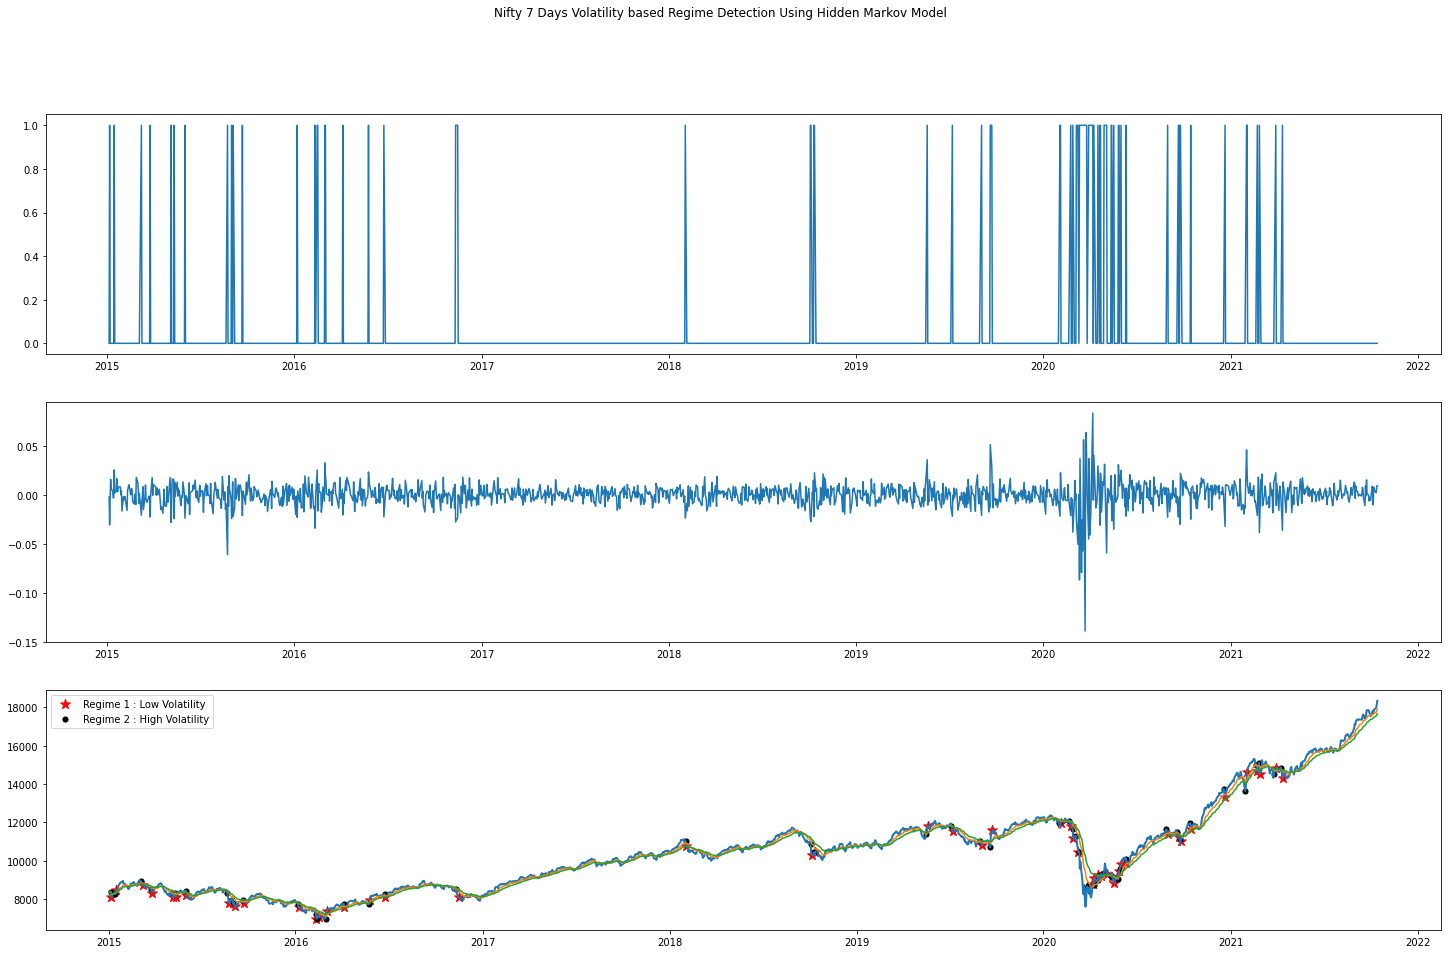

In [28]:
fig, ax = plt.subplots(figsize=(25,15),sharex=True)
plt.subplot(311)
plt.plot(zi.Volatility[:])
plt.subplot(312)
plt.plot(returns[:])
plt.subplot(313)
plt.plot(df['Close'][:],linewidth=2)
plt.plot(df["Close"].ewm(span=13).mean())
plt.plot(df["Close"].ewm(span=26).mean())
plt.scatter(df.iloc[buy][:].index,df.iloc[buy][:].Close,marker='*',s=105,color='r',label='Regime 1 : Low Volatility')
plt.scatter(df.iloc[sell][:].index,df.iloc[sell][:].Close,marker='.',s=105,color='black',label='Regime 2 : High Volatility')
plt.legend()
plt.suptitle('Nifty 7 Days Volatility based Regime Detection Using Hidden Markov Model')
plt.show();

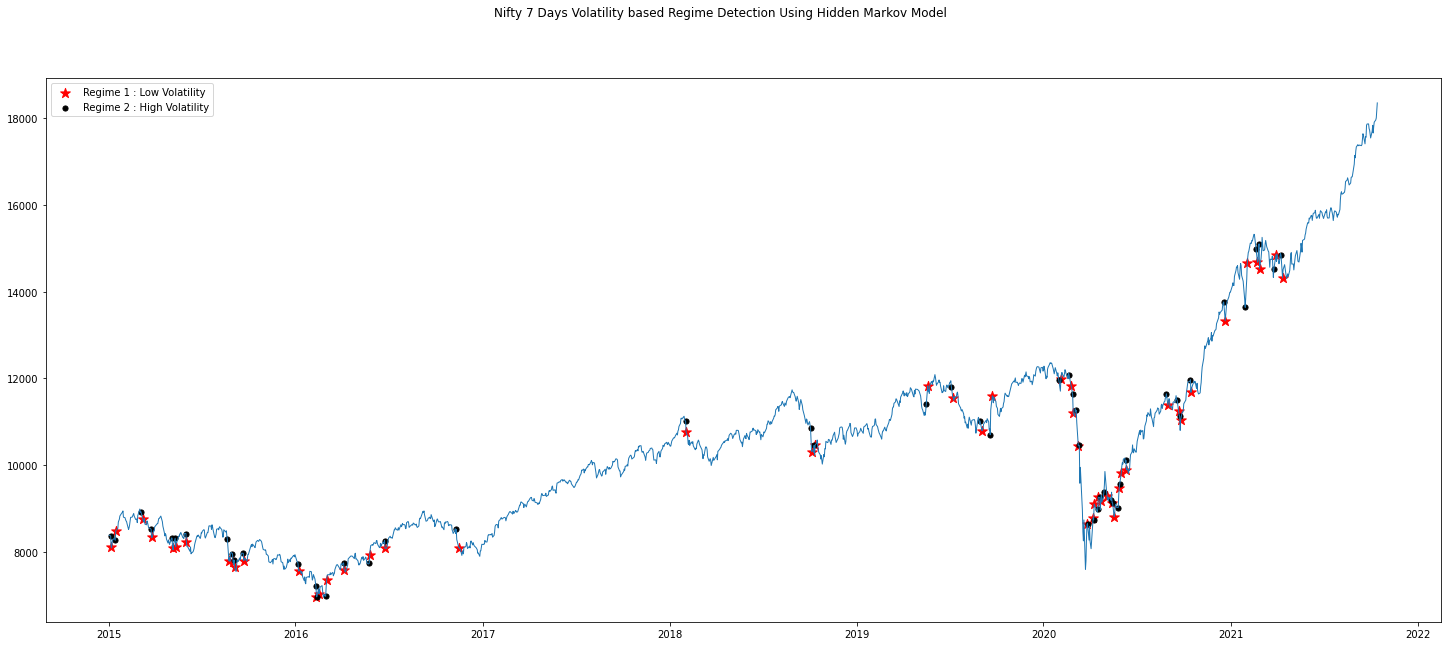

In [29]:
fig, ax = plt.subplots(figsize=(25,10),sharex=True)
plt.plot(df['Close'][:],linewidth=1)
#plt.plot(df["Close"].ewm(span=13).mean(),color='g')
#plt.plot(df["Close"].ewm(span=26).mean(),color='r')
plt.scatter(df.iloc[buy][:].index,df.iloc[buy][:].Close,marker='*',s=105,color='r',label='Regime 1 : Low Volatility')
plt.scatter(df.iloc[sell][:].index,df.iloc[sell][:].Close,marker='.',s=105,color='black',label='Regime 2 : High Volatility')
plt.legend()
plt.suptitle('Nifty 7 Days Volatility based Regime Detection Using Hidden Markov Model')
plt.show();

In [30]:
buy[-1],sell[-1]

(1538, 1537)

In [31]:
lst=[buy[-1],sell[-1]]
max(lst)

1538

In [32]:
df.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-10-13,18097.849609,18197.800781,18050.750000,18161.750000,18161.750000,506700
2021-10-14,18272.849609,18350.750000,18248.699219,18338.550781,18338.550781,538700


In [33]:
'''
if High_vol=0:
  df.loc[0,'Regime']='High Volatility'
if High_vol=1: 
  df.loc[0,'Regime']='High Volatility' 
'''  

"\nif High_vol=0:\n  df.loc[0,'Regime']='High Volatility'\nif High_vol=1: \n  df.loc[0,'Regime']='High Volatility' \n"

In [34]:
df=pd.concat([df,zi.Volatility],axis=1)

In [35]:
df.Volatility.value_counts()

0.0    1585
1.0      80
Name: Volatility, dtype: int64

In [36]:
if df['Volatility'][-1]!=df['Volatility'][-2]:
  print(f'Change in Regime ---> Present Regime {df["Volatility"][-1]}')
else:
  print(f'No Change in Regime We are in The Regime of : {df["Volatility"][-1]}') 


No Change in Regime We are in The Regime of : 0.0


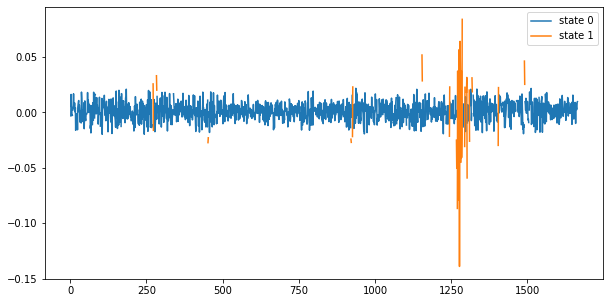

In [37]:
# we want to draw different segments in different colors according to state
fig, ax = plt.subplots(figsize=(10, 5))



# fill in the values only if the state is the one corresponding to the array
returns0[Z == 0] = returns[Z == 0]
returns1[Z == 1] = returns[Z == 1]
plt.plot(returns0, label='state 0')
plt.plot(returns1, label='state 1')
plt.legend();

In [38]:
zi.head(2)

,pct_chg,pred,Volatility
Date,,,
2015-01-05,-0.002033,0,0.0
2015-01-06,-0.030422,1,1.0


In [39]:
len(Z)

1665